In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *

In [2]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cpu


In [3]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

In [4]:
# Get IDs
try:
    ids = next(os.walk(PATH))[1]
    #print(ids)
except StopIteration:
    pass # Some error handling here

#print("HERE")

# Get and resize images and masks
X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype= np.float32)
Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype= np.float32)
#print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    path = PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask
#print('Done!')


100%|██████████| 670/670 [01:18<00:00,  8.52it/s]


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


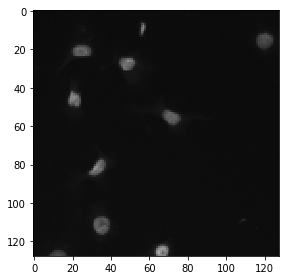

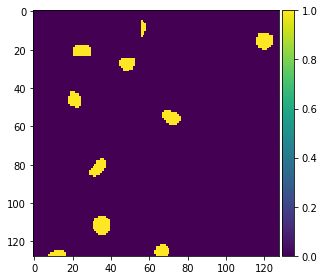

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [6]:
# Splitting data into train/val/test set in a 60/20/20 split
shuffled_indices = np.random.permutation(len(X))

train_indices = shuffled_indices[0:int(.6*(len(X)))]
val_indices = shuffled_indices[int(.6*(len(X))): int(.8*(len(X)))]
test_indices = shuffled_indices[int(.8*(len(X))):]

X_train = X[train_indices]
Y_train = Y[train_indices]
Y_train[Y_train.nonzero()] = 1
X_val = X[val_indices]
Y_val = Y[val_indices]
Y_val[Y_val.nonzero()] = 1
X_test = X[test_indices]
Y_test = Y[test_indices]
Y_test[Y_test.nonzero()] = 1

# Let us visualize what inputs outputs look like
randIndex = random.randint(0, len(X_train))
imshow(np.uint8(X_train[randIndex]))
plt.show()
imshow(np.squeeze(np.uint8(Y_train[randIndex])))
plt.show()

# X_train /= 256
# X_val /= 256
# X_test /= 256

X_train = np.transpose(X_train, (0,3,1,2))
Y_train = np.transpose(Y_train, (0,3,1,2))
X_val = np.transpose(X_val, (0,3,1,2))
Y_val = np.transpose(Y_val, (0,3,1,2))
X_test = np.transpose(X_test, (0,3,1,2))
Y_test = np.transpose(Y_test, (0,3,1,2))

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

In [7]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.show()

In [8]:
def calc_iou(preds, y):
    preds = preds.view(preds.shape[0], -1)
    y = y.view(y.shape[0], -1)
    intersection = y.take(preds.nonzero()).sum()
    union = y.sum() + (preds.type(torch.float)).sum() - intersection
    return (intersection/(union + epsilon))

In [9]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64,visual = False):
    model.eval() #set model to evaluation mode
    mean_iou = 0
    num_batches = int(len(X_perf)/mini_batch_size)
    num_remaining = len(X_perf) - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            x = x.to(device = device, dtype = dtype)
            y = y.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5)
            mean_iou += float(mini_batch_size)*calc_iou(preds, y)
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :])
        x = x.to(device = device, dtype = dtype)
        y = y.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5)
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), len(X_perf))
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].numpy())
        mean_iou += float(num_remaining)*calc_iou(preds, y)
    return (mean_iou/(float(len(X_perf))))

In [10]:
def trainModel(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(len(x_train)/mini_batch_size)
    num_remaining = len(x_train) - num_batches *mini_batch_size
    loss_history = []
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(len(x_train), mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, currLoss))
            if (num_remaining <= 0 and t == (num_batches -1)):
                iou = calculatePerformance(x_train, y_train, model)
                print('Train Mean IOU at epoch %d is %.4f' % (e, iou))
                if (noVal == False):
                    iou = calculatePerformance(X_val, Y_val, model)
                    print('Val Mean IOU at epoch %d is %.4f' % (e, iou))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, num_batches, currLoss))
            iou = calculatePerformance(x_train, y_train, model)
            print('Train Mean IOU at epoch %d is %.4f' % (e, iou))
            if (noVal == False):
                iou = calculatePerformance(X_val, Y_val, model)
                print('Val Mean IOU at epoch %d is %.4f' % (e, iou))
            T +=1
    return calculatePerformance(x_train, y_train, model),loss_history

In [11]:
# Overfitting data first
bestPerf = -1
bestModel = None
lrUsed = 0
x_train = X_train[0:50, :, :, :]
y_train = Y_train[0:50, :, :, :]
for lr in [5e-4, 1e-3, 1.5e-3]:
    print('Trying out learning rate of ', lr)
    model = UNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf = trainModel(model, x_train, y_train, optimizer, epochs = 5, noVal = True)
    if modelPerf[0] > bestPerf:
        bestPerf = modelPerf[0]
        bestModel = model
        lrUsed = lr

Trying out learning rate of  0.0005
Epoch 0, Iteration 0, loss = 8.9847
Train Mean IOU at epoch 0 is 0.8378
Epoch 1, Iteration 0, loss = 7.8963
Train Mean IOU at epoch 1 is 0.8049
Epoch 2, Iteration 0, loss = 7.1507
Train Mean IOU at epoch 2 is 0.7720
Epoch 3, Iteration 0, loss = 6.6537
Train Mean IOU at epoch 3 is 0.7135
Epoch 4, Iteration 0, loss = 4.4044
Train Mean IOU at epoch 4 is 0.6698
Trying out learning rate of  0.001
Epoch 0, Iteration 0, loss = 8.9351
Train Mean IOU at epoch 0 is 0.6970
Epoch 1, Iteration 0, loss = 5.5240
Train Mean IOU at epoch 1 is 0.6423
Epoch 2, Iteration 0, loss = 4.1432
Train Mean IOU at epoch 2 is 0.5303
Epoch 3, Iteration 0, loss = 2.9940
Train Mean IOU at epoch 3 is 0.4470
Epoch 4, Iteration 0, loss = 2.7956
Train Mean IOU at epoch 4 is 0.3764
Trying out learning rate of  0.0015
Epoch 0, Iteration 0, loss = 3.9075
Train Mean IOU at epoch 0 is 0.2217
Epoch 1, Iteration 0, loss = 2.9589
Train Mean IOU at epoch 1 is 0.0845
Epoch 2, Iteration 0, loss = 

Best learning rate used to train was  0.0005


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


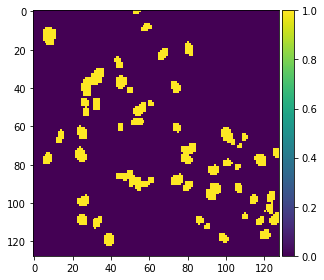

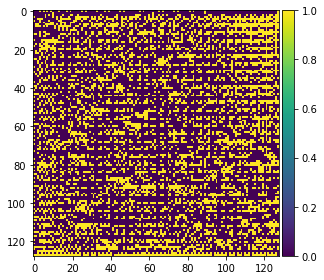

Best train IOU =  tensor(0.6698)


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Let us visualize how different our predicted masks are
print('Best learning rate used to train was ', lrUsed)
print('Best train IOU = ', (calculatePerformance(x_train, y_train, bestModel, visual = True))[0])